In [63]:
import os
from collections import defaultdict
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tqdm import tqdm
import string

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = "../data"
os.listdir(data_dir)

['bus_stops_wszone.dbf',
 'bus_stops_wszone.shp',
 'singstat',
 'net_202001_15.net',
 'OD_bus',
 'net_202001_05.net',
 'net_202001_06.net',
 'origin_destination_train_201912.csv.xz',
 'train_station_wszone.prj',
 'origin_destination_train_202001.csv.xz',
 'train_station_wszone.dbf',
 'OD_202001_weekend.csv.xz',
 'net_202001_22.net',
 'subzone_centroid.csv',
 'OD_201912_weekday.csv.xz',
 'origin_destination_bus_201911.csv.xz',
 'net_202001_19.net',
 'net_202001_18.net',
 'train_station_wszone.cpg',
 'OD_PT',
 'train_station_wszone.shx',
 'net_202001_10.net',
 'OD_201911_weekend.csv.xz',
 'origin_destination_train_201911.csv.xz',
 'planning-area-2014',
 'net_202001_weekend.net',
 'subzone_centroid_pos.json',
 '.ipynb_checkpoints',
 'net_202001_21.net',
 'origin_destination_bus_202001.csv.xz',
 'OD_201912_weekend.csv.xz',
 'net_202001_07.net',
 'origin_destination_bus_201912.csv.xz',
 'net_202001_23.net',
 'region-2014',
 'train_station_wszone.shp',
 'net_202001_weekday.net',
 'net_202001

In [4]:
region = gpd.read_file("../data/region-2014/MP14_REGION_WEB_PL.shp")
parea = gpd.read_file("../data/planning-area-2014/MP14_PLNG_AREA_WEB_PL.shp")

In [5]:
subzone_fp = os.path.join(data_dir, "subzone-2014", "MP14_SUBZONE_WEB_PL.shp")
subzone = gpd.read_file(subzone_fp)
subzone.head()

,OBJECTID,SUBZONE_NO,SUBZONE_N,SUBZONE_C,CA_IND,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,X_ADDR,Y_ADDR,SHAPE_Leng,SHAPE_Area,geometry
0,1,1,MARINA SOUTH,MSSZ01,Y,MARINA SOUTH,MS,CENTRAL REGION,CR,5ED7EB253F99252E,2014-12-05,31595.8357,29220.1873,5267.381024,1.630379e+06,"POLYGON ((31495.560 30140.012, 31980.957 29671..."
1,2,1,PEARL'S HILL,OTSZ01,Y,OUTRAM,OT,CENTRAL REGION,CR,8C7149B9EB32EEFC,2014-12-05,28679.0634,29782.0519,3506.107376,5.598162e+05,"POLYGON ((29092.275 30021.888, 29119.641 30006..."
2,3,3,BOAT QUAY,SRSZ03,Y,SINGAPORE RIVER,SR,CENTRAL REGION,CR,C35FEFF02B13E0E5,2014-12-05,29654.9594,29974.6553,1740.925766,1.608075e+05,"POLYGON ((29932.332 29879.120, 29947.317 29858..."
3,4,8,HENDERSON HILL,BMSZ08,N,BUKIT MERAH,BM,CENTRAL REGION,CR,3775D82C5DDBEFBD,2014-12-05,26782.8261,29933.7651,3313.624904,5.954289e+05,"POLYGON ((27131.276 30059.727, 27088.334 29709..."
4,5,3,REDHILL,BMSZ03,N,BUKIT MERAH,BM,CENTRAL REGION,CR,85D9ABEF0A40678F,2014-12-05,26201.9580,30005.7035,2825.594099,3.874294e+05,"POLYGON ((26451.027 30396.458, 26440.474 30361..."


In [7]:
sr_weekday = pd.read_csv("Super_SR_lvl_weekday.csv", index_col=0)
sr_weekend = pd.read_csv("Super_SR_lvl_weekend.csv", index_col=0)

In [8]:
sr_weekday.head()

,node,lvl_dc_spreader,lvl_hh,lvl_pr_spreader,lvl_dc_receiver,lvl_ha,lvl_pr_receiver
ind,,,,,,,
0,TAMPINES EAST,1,1,1,1,1,1
1,BEDOK NORTH,3,1,3,3,1,3
2,TOA PAYOH CENTRAL,1,2,1,1,2,1
3,ALJUNIED,1,1,1,2,1,2
4,TAMPINES WEST,3,1,3,3,1,3


In [11]:
subzone2 = subzone.merge(sr_weekday, left_on="SUBZONE_N", right_on="node")
print(len(subzone2))
subzone2.head()

303


,OBJECTID,SUBZONE_NO,SUBZONE_N,SUBZONE_C,CA_IND,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,INC_CRC,...,SHAPE_Leng,SHAPE_Area,geometry,node,lvl_dc_spreader,lvl_hh,lvl_pr_spreader,lvl_dc_receiver,lvl_ha,lvl_pr_receiver
0,1,1,MARINA SOUTH,MSSZ01,Y,MARINA SOUTH,MS,CENTRAL REGION,CR,5ED7EB253F99252E,...,5267.381024,1.630379e+06,"POLYGON ((31495.560 30140.012, 31980.957 29671...",MARINA SOUTH,3,3,3,3,3,3
1,2,1,PEARL'S HILL,OTSZ01,Y,OUTRAM,OT,CENTRAL REGION,CR,8C7149B9EB32EEFC,...,3506.107376,5.598162e+05,"POLYGON ((29092.275 30021.888, 29119.641 30006...",PEARL'S HILL,3,3,3,3,3,3
2,3,3,BOAT QUAY,SRSZ03,Y,SINGAPORE RIVER,SR,CENTRAL REGION,CR,C35FEFF02B13E0E5,...,1740.925766,1.608075e+05,"POLYGON ((29932.332 29879.120, 29947.317 29858...",BOAT QUAY,3,3,3,3,3,3
3,4,8,HENDERSON HILL,BMSZ08,N,BUKIT MERAH,BM,CENTRAL REGION,CR,3775D82C5DDBEFBD,...,3313.624904,5.954289e+05,"POLYGON ((27131.276 30059.727, 27088.334 29709...",HENDERSON HILL,3,3,3,3,3,3
4,5,3,REDHILL,BMSZ03,N,BUKIT MERAH,BM,CENTRAL REGION,CR,85D9ABEF0A40678F,...,2825.594099,3.874294e+05,"POLYGON ((26451.027 30396.458, 26440.474 30361...",REDHILL,3,3,3,3,3,3


In [12]:
subzone3 = subzone.merge(sr_weekend, left_on="SUBZONE_N", right_on="node")
print(len(subzone3))
subzone3.head()

303


,OBJECTID,SUBZONE_NO,SUBZONE_N,SUBZONE_C,CA_IND,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,INC_CRC,...,SHAPE_Leng,SHAPE_Area,geometry,node,lvl_dc_spreader,lvl_hh,lvl_pr_spreader,lvl_dc_receiver,lvl_ha,lvl_pr_receiver
0,1,1,MARINA SOUTH,MSSZ01,Y,MARINA SOUTH,MS,CENTRAL REGION,CR,5ED7EB253F99252E,...,5267.381024,1.630379e+06,"POLYGON ((31495.560 30140.012, 31980.957 29671...",MARINA SOUTH,3,3,3,3,3,3
1,2,1,PEARL'S HILL,OTSZ01,Y,OUTRAM,OT,CENTRAL REGION,CR,8C7149B9EB32EEFC,...,3506.107376,5.598162e+05,"POLYGON ((29092.275 30021.888, 29119.641 30006...",PEARL'S HILL,3,3,3,3,3,3
2,3,3,BOAT QUAY,SRSZ03,Y,SINGAPORE RIVER,SR,CENTRAL REGION,CR,C35FEFF02B13E0E5,...,1740.925766,1.608075e+05,"POLYGON ((29932.332 29879.120, 29947.317 29858...",BOAT QUAY,3,3,3,3,3,3
3,4,8,HENDERSON HILL,BMSZ08,N,BUKIT MERAH,BM,CENTRAL REGION,CR,3775D82C5DDBEFBD,...,3313.624904,5.954289e+05,"POLYGON ((27131.276 30059.727, 27088.334 29709...",HENDERSON HILL,3,3,3,3,3,3
4,5,3,REDHILL,BMSZ03,N,BUKIT MERAH,BM,CENTRAL REGION,CR,85D9ABEF0A40678F,...,2825.594099,3.874294e+05,"POLYGON ((26451.027 30396.458, 26440.474 30361...",REDHILL,3,3,3,3,3,3


In [29]:
with open(os.path.join("../data", 'subzone_centroid_pos.json'), 'r') as fread:
    pos = json.load(fread)
pos["MARINA SOUTH"]

[31595.83574613999, 29220.18737674884]

In [30]:

def get_pos(nodes, pos):
    xs = []
    ys = []
    for n in nodes:
        x,y = pos[n]
        xs.append(x)
        ys.append(y)
    return xs, ys

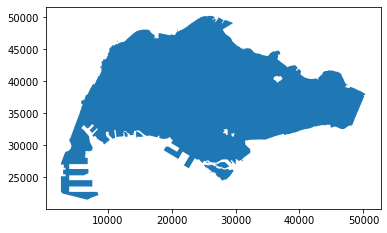

In [14]:
union_geom = gpd.GeoSeries(subzone2.geometry.unary_union)
union_geom.plot()

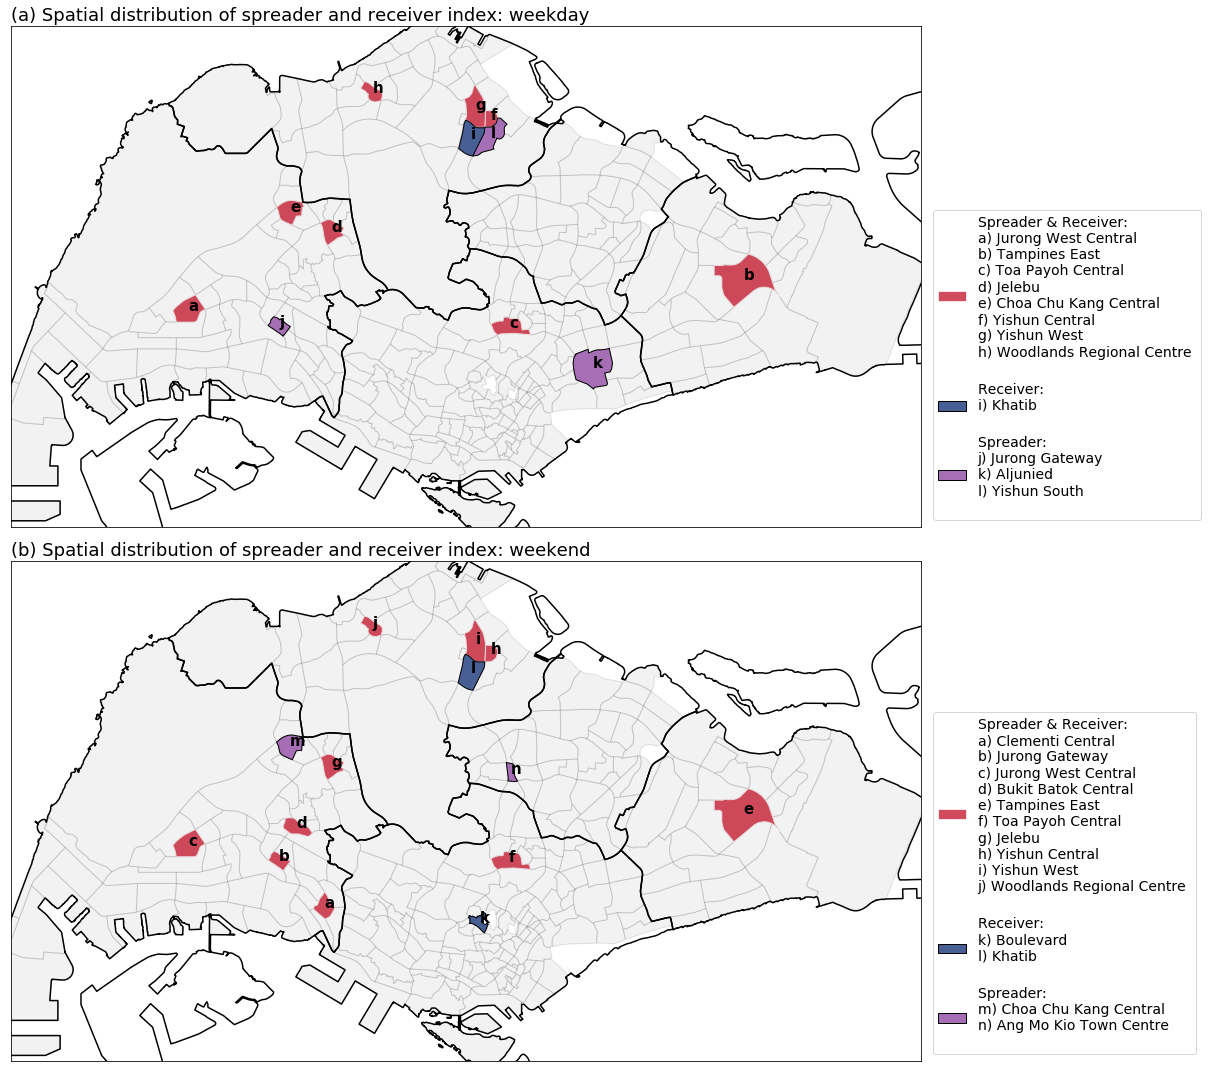

In [66]:
fig, axs = plt.subplots(2,1, figsize=(18,15))


for ax in axs:
    subzone2.plot(color="grey", edgecolor="k", alpha=0.1, ax=ax)
    #region.plot(color="none", edgecolor="k", alpha=0.8, ax=ax)

colors = ["xkcd:scarlet", "xkcd:dusky blue", "xkcd:soft purple"]

temp1 = subzone2[subzone2["lvl_dc_spreader"]==1]
temp1 = temp1[temp1["lvl_dc_receiver"]==1]
temp1.plot(ax=axs[0], fc=colors[0], ec="w", alpha=.7)
textsa1 = ""
idtext = list("abcdefgh")
ns = temp1["node"].tolist()
xx, yy = get_pos(ns, pos)
for i, txt in enumerate(idtext):
    axs[0].annotate(txt, (xx[i], yy[i]), fontsize=15, fontweight="bold")
    textsa1+="{}) {} \n".format(txt, string.capwords(ns[i]))


temp2 = subzone2[subzone2["lvl_dc_receiver"]==1]
temp2 = temp2[temp2["lvl_dc_spreader"]!=1]
temp2.plot(ax=axs[0], fc=colors[1], ec="k", lw=1)
textsb1 = ""
idtext = list("i")
ns = temp2["node"].tolist()
xx, yy = get_pos(ns, pos)
for i, txt in enumerate(idtext):
    axs[0].annotate(txt, (xx[i], yy[i]), fontsize=15, fontweight="bold")
    textsb1+="{}) {} \n".format(txt, string.capwords(ns[i]))

temp3 = subzone2[subzone2["lvl_dc_spreader"]==1]
temp3 = temp3[temp3["lvl_dc_receiver"]!=1]
temp3.plot(ax=axs[0], fc=colors[2], ec="k", lw=1)
textsc1 = ""
idtext = list("jkl")
ns = temp3["node"].tolist()
xx, yy = get_pos(ns, pos)
for i, txt in enumerate(idtext):
    axs[0].annotate(txt, (xx[i], yy[i]), fontsize=15, fontweight="bold")
    textsc1+="{}) {} \n".format(txt, string.capwords(ns[i]))



temp1 = subzone3[subzone3["lvl_dc_spreader"]==1]
temp1 = temp1[temp1["lvl_dc_receiver"]==1]
temp1.plot(ax=axs[1], fc=colors[0], ec="w", alpha=.7)
textsa2 = ""
idtext = list("abcdefghij")
ns = temp1["node"].tolist()
xx, yy = get_pos(ns, pos)
for i, txt in enumerate(idtext):
    axs[1].annotate(txt, (xx[i], yy[i]), fontsize=15, fontweight="bold")
    textsa2+="{}) {} \n".format(txt, string.capwords(ns[i]))

temp2 = subzone3[subzone3["lvl_dc_receiver"]==1]
temp2 = temp2[temp2["lvl_dc_spreader"]!=1]
temp2.plot(ax=axs[1], fc=colors[1], ec="k", lw=1)
textsb2 = ""
idtext = list("kl")
ns = temp2["node"].tolist()
xx, yy = get_pos(ns, pos)
for i, txt in enumerate(idtext):
    axs[1].annotate(txt, (xx[i], yy[i]), fontsize=15, fontweight="bold")
    textsb2+="{}) {} \n".format(txt, string.capwords(ns[i]))

temp3 = subzone3[subzone3["lvl_dc_spreader"]==1]
temp3 = temp3[temp3["lvl_dc_receiver"]!=1]
temp3.plot(ax=axs[1], fc=colors[2], ec="k", lw=1)
textsc2 = ""
idtext = list("mn")
ns = temp3["node"].tolist()
xx, yy = get_pos(ns, pos)
for i, txt in enumerate(idtext):
    axs[1].annotate(txt, (xx[i], yy[i]), fontsize=15, fontweight="bold")
    textsc2+="{}) {} \n".format(txt, string.capwords(ns[i]))

i = 0
labs = "ab"
labs2 = ["weekday", "weekend"]
textsa = [textsa1, textsa2]
textsb = [textsb1, textsb2]
textsc = [textsc1, textsc2]
for ax in axs:
    #union_geom.plot(fc="none", ec="k", lw=1.5, ax=ax)
    region.plot(color="none", ec="k", lw=1.5, alpha=1., ax=ax)
    ax.set_xlim([4500,50000])
    ax.set_ylim([25000,50000])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("({}) Spatial distribution of spreader and receiver index: {}".format(labs[i], labs2[i]), loc="left", fontsize=18)
    patches1 = []
    patches1.append(mpatches.Patch(color=colors[0], ec="w", label="Spreader & Receiver: \n"+textsa[i], alpha=.7))
    patches1.append(mpatches.Patch(color=colors[1], ec="k", lw=1, label="Receiver: \n"+textsb[i], alpha=1.))
    patches1.append(mpatches.Patch(color=colors[2], ec="k", lw=1, label="Spreader: \n"+textsc[i], alpha=1.))
    leg1 = ax.legend(handles=patches1, ncol=1, fontsize=14, loc="lower left", bbox_to_anchor=(1.005, 0.0))
    #leg1.set_title("Core for", prop={'size':14})
    i+=1



plt.tight_layout()
plt.savefig("figs/SR_result_map.png", dpi=100, bbox_inches="tight")